https://towardsdatascience.com/yolo-object-detection-with-opencv-and-python-21e50ac599e9

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pie_data import PIE
from os import listdir
from os.path import join

one image:

In [38]:
image = cv2.imread('../../zadanie2/images/set03/video_0001/08533.png')
Width = image.shape[1]
Height = image.shape[0]
scale = 0.00392

# read class names from text file
classes = None
with open('../yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]
print(classes)

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [39]:
# generate different colors for different classes 
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# read pre-trained model and config file
net = cv2.dnn.readNet('../yolov3.weights', '../yolov3.cfg')

# prepare the input image to run through the neural network
# create input blob 
blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

# set input blob for the network
net.setInput(blob)

In [40]:
# function to get the output layer names 
# in the architecture
def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    try:
        output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
    except:
        output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

In [41]:
# run inference through the network
# and gather predictions from output layers
outs = net.forward(get_output_layers(net))

In [44]:
type(outs[0][0][0])

numpy.float32

In [45]:
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4


for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])

In [46]:
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

for i in indices:
    try:
        box = boxes[i]
    except:
        i = i[0]
        box = boxes[i]
    
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    draw_bounding_box(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

cv2.imshow("object detection", image)
cv2.waitKey()
    
cv2.imwrite("../outputs/yolov3/object_detection.jpg", image)
cv2.destroyAllWindows()


multiple images

In [47]:
pie_path = '../../zadanie2/' #'/media/erik/T7/DP/PIE_data' # '../' 
pie = PIE(data_path=pie_path)
type(pie)

pie_data.PIE

In [48]:
train_list = pie._get_image_set_ids('train')
test_list = pie._get_image_set_ids('test')
val_list = pie._get_image_set_ids('val')

train_list, val_list, test_list

(['set01', 'set02', 'set04'], ['set05', 'set06'], ['set03'])

In [49]:
set_list = pie._get_image_set_ids('test')
set_list

['set03']

In [50]:
set_dir = dict()
all_path = list()
all_filenames = list()

for set_ in set_list:
    set_path = join(pie._images_path, set_)
    set_dir[set_] = dict()
    
    set_content = listdir(set_path)
    for video in set_content:
        video_path = join(set_path, video)
        imgs = listdir(video_path)
        all_path += ([video_path] * len(imgs))
        all_filenames += imgs
        set_dir[set_][video] = imgs
print(set_dir)

{'set03': {'video_0005': ['00471.png', '00473.png', '00477.png', '00478.png', '00476.png', '00472.png', '00469.png', '00466.png', '00465.png', '00479.png', '00475.png', '00467.png', '00468.png', '00480.png', '00470.png', '00474.png'], 'video_0012': ['07204.png', '07205.png', '07208.png', '07198.png', '07193.png', '07203.png', '07206.png', '07194.png', '07202.png', '07207.png', '07201.png', '07196.png', '07199.png', '07200.png', '07197.png', '07195.png'], 'video_0011': ['00332.png', '00336.png', '00347.png', '00339.png', '00343.png', '00340.png', '00342.png', '00341.png', '00335.png', '00337.png', '00338.png', '00334.png', '00344.png', '00346.png', '00333.png', '00345.png'], 'video_0009': ['03064.png', '03065.png', '03073.png', '03061.png', '03058.png', '03063.png', '03066.png', '03070.png', '03072.png', '03068.png', '03062.png', '03059.png', '03060.png', '03069.png', '03071.png', '03067.png'], 'video_0015': ['02096.png', '02088.png', '02094.png', '02086.png', '02084.png', '02091.png', 

In [51]:
print(all_path)


['../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0005', '../../zadanie2/images/set03/video_0012', '../../zadanie2/images/set03/video_0012', '../../zadanie2/images/set03/video_0012', '../../zadanie2/images/set03/video_0012', '../../zadanie2/images/set03/video_0012', '../../zadanie2/images/set03/video_0012', '../../zadanie2/images/set03/video_0012', '../../zadanie2/images/set03/vide

In [ ]:
# initialize the list of images we'll be passing through the network
images = []
# loop over the input images (excluding the first one since we
# already classified it), pre-process each image, and update the
# `images` list
for set_key in set_dir:
	for video in set_dir[set_key]:
		for frame in set_dir[set_key][video]:
			path = '../../zadanie2/images/' + set_key + '/' + video + '/' + frame
			#print(path)
			image = cv2.imread(path)
			image = cv2.resize(image, (400, 200))
			images.append(image)

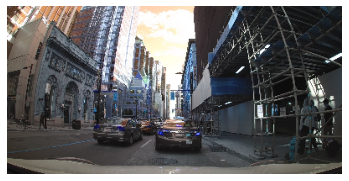

In [54]:
plt.imshow(images[-1], cmap='gray')
plt.axis('off')
plt.show()

In [32]:
# initialization
class_ids = dict()
confidences = dict()
boxes = dict()
conf_threshold = 0.5
nms_threshold = 0.4

# for each detetion from each output layer 
# get the confidence, class id, bounding box params
# and ignore weak detections (confidence < 0.5)
count = 0
for img in outs:
    class_ids[count] = []
    confidences[count] = []
    boxes[count] = []
    for out in img:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids[count].append(class_id)
                confidences[count].append(float(confidence))
                boxes[count].append([x, y, w, h])
    count += 1

In [31]:
type(class_ids)

list

In [37]:
count = 0
for image in images:
    indices = cv2.dnn.NMSBoxes(boxes[count], confidences[count], conf_threshold, nms_threshold)

    for i in indices:
        try:
            box = boxes[count][i]
        except:
            print(count, i)
            i = i[0]
            box = boxes[count][i]
        
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        draw_bounding_box(image, class_ids[count][i], confidences[count][i], round(x), round(y), round(x+w), round(y+h))
        img_resize = cv2.resize(image, (800, 600))
        #cv2.imshow("object detection", img_resize)
        #cv2.waitKey()
            
        cv2.imwrite("object-detection_{count}.jpg", image)
        count += 1
        cv2.destroyAllWindows()

3 93


IndexError: invalid index to scalar variable.